## Malaria transmission process parameters

In [1]:
params = {
    "rainfall_multiplier" : 1.0, # rainfall to mosquito linear multiplication factor (per day)
    "rainfall_offset" : 0.0, # rainfall to mosquito offset
    "c" : 1.0, # inoculation effiency for mosquitoes
    "b": 0.5, # inoculation efficiency for humans
    "hbi" : 0.5, # human blood index
    "r" : 0.0284, # human recovery rate (per day)
    "hia" : 15.0, # number of days after infection when humans become infectious
    "Tg" : 9.0, #  Gonotrophic threshold temperature 
    "Dg" : 37.0, # Gonotrophic cycle length in degree days
    "Ts" : 18.0, # Sporogonic threshold temperature 
    "Ds" : 111.0, # Sporoogonic cycle length in degree days
    "stype" : 0 # Survival type (valid values are 0 = Martens, 2 = Craig)
}

In [123]:
import pandas as pd
from models.R0_model import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [21]:
dataset = 'seasonal_forecasts.csv'

In [32]:
df = pd.read_csv('datasets/'+dataset)
df.head()

,forecast,precip,temp,datetime
0,1,0.576628,17.865900,2017-01-01
1,1,0.166432,18.287195,2018-01-01
2,1,1.760069,19.013910,2019-01-01
3,1,0.000000,16.801691,2020-01-01
4,1,0.950271,17.495355,2021-01-01


In [33]:
def preprocess(data):
    
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['year'] = data['datetime'].dt.year.astype(int)
    data['month'] = data['datetime'].dt.month.astype(int)
    data['day_of_month'] = data['datetime'].dt.day.astype(int)
    data['day_of_year'] = data['datetime'].dt.dayofyear.astype(int)
    data['season'] = np.where(data['month'].between(1, 6),"Spring","Fall")
    
    return data

In [34]:
df = preprocess(df)
df.tail()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season
91295,50,0.000000,16.260675,2017-12-31,2017,12,31,365,Fall
91296,50,2.108539,19.631158,2018-12-31,2018,12,31,365,Fall
91297,50,23.831091,14.834802,2019-12-31,2019,12,31,365,Fall
91298,50,0.000000,21.807184,2020-12-31,2020,12,31,366,Fall
91299,50,6.121696,18.742517,2021-12-31,2021,12,31,365,Fall


## Calculate the components of R0: (1) Mosquito population survival per day

In [35]:
df['P'] = mos_survival(params['stype'], df['temp'].values)
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009


## Calculate the components of R0: (2) Gonotrophic and Sporogonic cycle lengths

In [36]:
df['gono_len'] = gono_length(df['temp'].values, params['Dg'], params['Tg'])
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321


In [37]:
df['sporo_len'] = sporo_length(df['temp'].values, params['Ds'], params['Ts'])
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len,sporo_len
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293,1000.000000
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980,386.497216
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860,109.477182
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562,1000.000000
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321,1000.000000


## Calculate the components of R0: (3) Mosquito population
## Bring all components together and calculate R0

In [120]:
df_mospop = pd.DataFrame()
for iyear in df['year'].unique():
    data_yearly = df[df['year']==iyear].copy()
    for iseason in data_yearly['season'].unique():
        data_seasonal = data_yearly[data_yearly['season']==iseason].copy()
        for iforecast in data_seasonal['forecast'].unique():
            df_curr = data_seasonal[data_seasonal['forecast']==iforecast]
            p_array = df_curr['P'].values.reshape((1,1,len(df_curr)))
            r_array = df_curr['precip'].values.reshape((1,1,len(df_curr)))
            g_array = df_curr['gono_len'].values.reshape((1,1,len(df_curr)))
            s_array = df_curr['sporo_len'].values.reshape((1,1,len(df_curr)))
            d_array = df_curr['day_of_year'].values.reshape((1,1,len(df_curr)))
            m_array = calc_mosquito_pop(0.0, p_array, r_array, 1, params["rainfall_multiplier"], params["rainfall_offset"])
            R0 = calculate_R0(m_array, p_array, g_array, s_array, params["r"], \
                             params["hia"], params["hbi"], params["b"], params["c"])
            df_mospop_curr = pd.DataFrame(np.array([
                                            #d_array.reshape(len(df_curr)).astype(int),
                                            m_array.reshape(len(df_curr)),
                                            R0.reshape(len(df_curr))]
                                            ).T, 
                                          columns=['mosquitoes', 'R0'])
            df_mospop_curr['year'] = iyear.astype(int)
            df_mospop_curr['season'] = iseason
            df_mospop_curr['forecast'] = iforecast.astype(int)
            df_mospop_curr['day_of_year'] = df_curr['day_of_year'].values
            df_mospop = pd.concat([df_mospop, df_mospop_curr], ignore_index=True)
df = pd.merge(df, df_mospop, on=['year', 'season', 'forecast', 'day_of_year'], how='left')
df

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len,sporo_len,mosquitoes,R0
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293,1000.000000,0.000000,0.000000e+00
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980,386.497216,0.000000,0.000000e+00
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860,109.477182,0.000000,0.000000e+00
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562,1000.000000,0.000000,0.000000e+00
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321,1000.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91295,50,0.000000,16.260675,2017-12-31,2017,12,31,365,Fall,0.905021,6.095945,1000.000000,32.306927,1.141342e-42
91296,50,2.108539,19.631158,2018-12-31,2018,12,31,365,Fall,0.893471,4.480336,68.049796,14.022683,8.358339e-03
91297,50,23.831091,14.834802,2019-12-31,2019,12,31,365,Fall,0.898965,7.341260,1000.000000,19.118897,5.296203e-46
91298,50,0.000000,21.807184,2020-12-31,2020,12,31,366,Fall,0.866703,3.889004,29.155408,2.806308,5.755773e-02


In [243]:
df.month

0         1
1         1
2         1
3         1
4         1
         ..
91295    12
91296    12
91297    12
91298    12
91299    12
Name: month, Length: 91300, dtype: int64

In [241]:
df.to_csv('datasets/R0_malaria_model_variables.csv', index=False)

## Visual dataset exploration

In [238]:
def plot_ensembles(df, variable, figname=None):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    for iforecast in df['forecast'].unique():
        df_plot = df[df['forecast']==iforecast].sort_values(by=['datetime'])
        ax.plot(df_plot['datetime'], df_plot[variable], alpha = 0.1, c='C0')

    fig.autofmt_xdate()
    ax.grid(axis='x', ls=":", color='0.5')
    ax.set_ylabel(variable)
    ax.set_xlabel("Date")
    if figname:
        fig.savefig(figname, bbox_inches='tight')

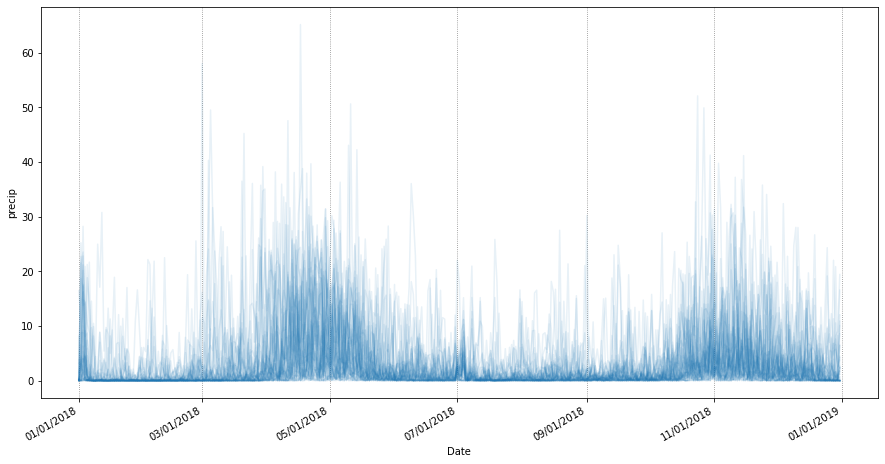

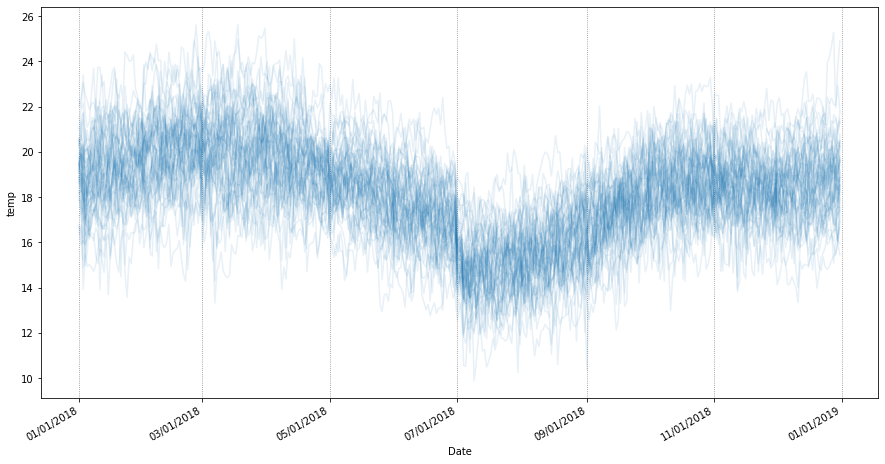

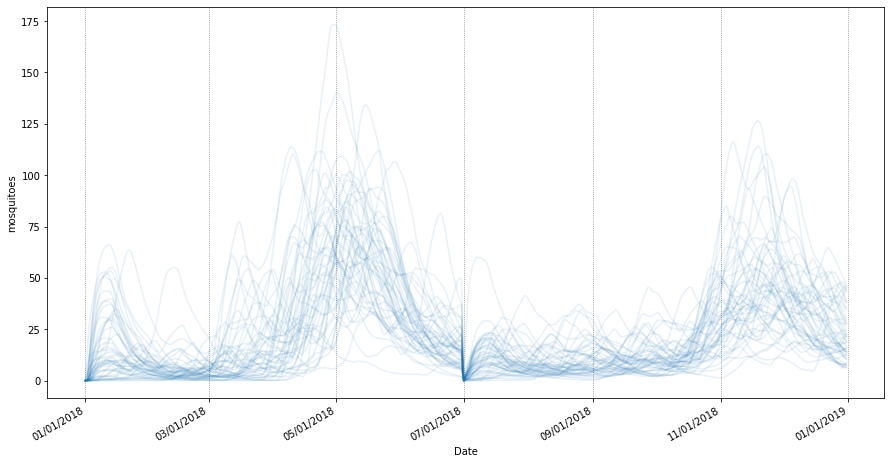

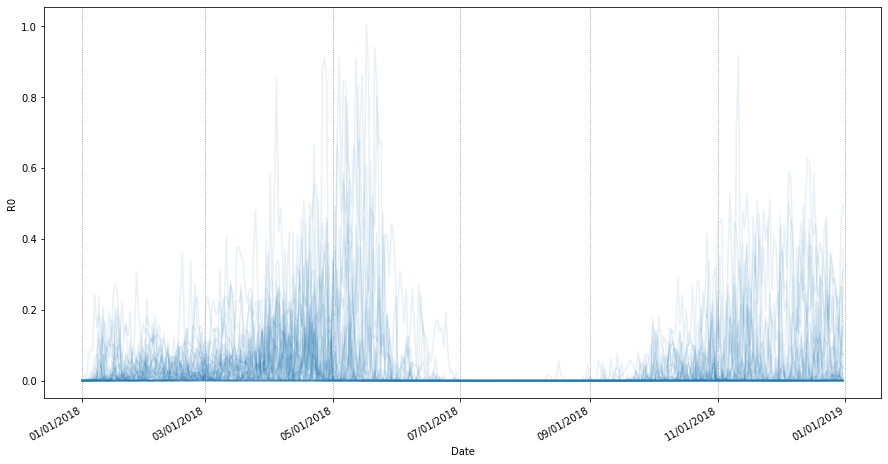

In [240]:
year = 2018
df_plot = df[df['year']==year].copy()
#f_plot = df.copy()
plot_ensembles(df_plot, 'precip')
plot_ensembles(df_plot, 'temp')
plot_ensembles(df_plot, 'mosquitoes')
plot_ensembles(df_plot, 'R0')

In [164]:
df_assembled = df[['datetime', 'year', 'temp', 'precip', 'R0']].copy()
df_assembled = df_assembled.groupby('datetime').agg({'year':'mean', 'temp':'mean', 'precip':'mean', 'R0':'mean'})
df_assembled

,year,temp,precip,R0
datetime,,,,
2017-01-01,2017,18.241119,1.527156,0.000000
2017-01-02,2017,18.265256,0.531480,0.000102
2017-01-03,2017,18.254780,0.465917,0.000485
2017-01-04,2017,17.976792,0.453789,0.000815
2017-01-05,2017,18.001762,0.363931,0.002061
...,...,...,...,...
2021-12-27,2021,18.521707,1.277858,0.016929
2021-12-28,2021,18.694518,2.160656,0.022980
2021-12-29,2021,18.633818,1.549790,0.018203


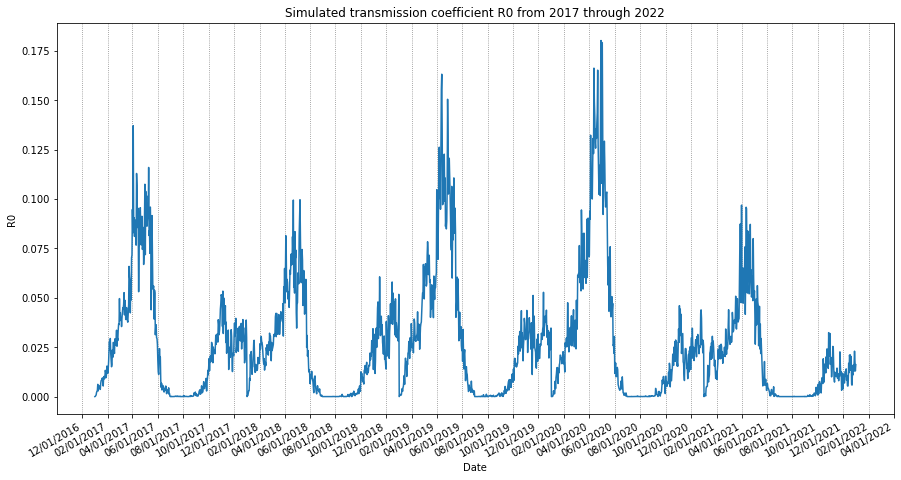

In [203]:
fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.plot(df_assembled.index, df_assembled['R0'], linestyle=None, marker='None', ms=8, mew=2, alpha = 1, c='C0')
#ax.plot(df2_assembled.index.values, df2_assembled['R0'].values, linestyle=None, marker='None', ms=8, mew=2, alpha = 1, c='C1')

#ax.set_xlim(df_assembled.index[0], df_assembled.index[-1])
fig.autofmt_xdate()
ax.grid(axis='x', ls=":", color='0.5')
ax.set_ylabel("R0")
ax.set_xlabel("Date")
ax.set_title("Simulated transmission coefficient R0 from 2017 through 2022");


In [158]:
df2 = pd.read_csv('datasets/forecast and query loop clim and R0 2017-2021.csv')

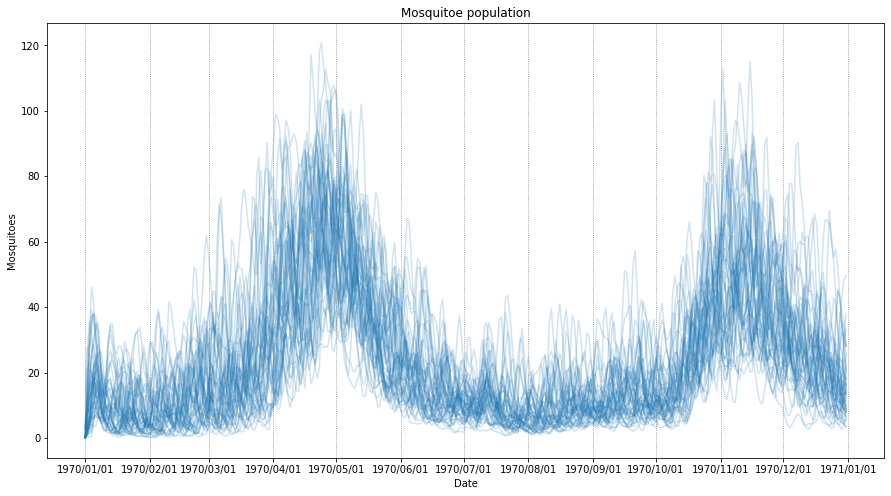

In [177]:
formatter = mdates.DateFormatter("%Y/%m/%d")
locator = mdates.MonthLocator()

fig = plt.figure(1, figsize=(15,8))

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

year = 2018
#ax.plot(plot_dates, values, linestyle=None, marker='+', ms=8, mew=2)
for ens in df['forecast'].unique():
    df_plot = df2[(df2['forecast']==ens) & (df2['year']==year)]
    ax.plot(df_plot['datetime'].values, df_plot['mosquitoes'].values, linestyle=None, marker='None', ms=8, mew=2, alpha = 0.2, c='C0')
    
#ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('Mosquitoes')
plt.xlabel("Date")
plt.title("Mosquitoe population")
#plt.savefig("mosquitoes_50_ens_Jan-June_2021.png")
plt.show()

In [165]:
df2_assembled = df2[['datetime', 'year', 'temp', 'precip', 'R0']].copy()
df2_assembled = df2_assembled.groupby('datetime').agg({'year':'mean', 'temp':'mean', 'precip':'mean', 'R0':'mean'})
df2_assembled

,year,temp,precip,R0
datetime,,,,
2017-01-01,2017,18.241119,1.527156,0.000000
2017-01-02,2017,18.265256,0.531480,0.009219
2017-01-03,2017,18.254780,0.465917,0.028425
2017-01-04,2017,17.976792,0.453789,0.043422
2017-01-05,2017,18.001762,0.363931,0.038168
...,...,...,...,...
2021-12-27,2021,18.521707,1.277858,0.016350
2021-12-28,2021,18.694518,2.160656,0.031909
2021-12-29,2021,18.633818,1.549790,0.024234
